In [1]:
import os
import mne
import numpy as np
import warnings
import pyedflib
import tensorflow as tf
from mne.io import concatenate_raws
from autoreject import get_rejection_threshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

mne.set_log_level(verbose=False)

# **Data Preparations**

## Raw Data

In [2]:
def load_data(subject_id:list, task_id:list, montage_name:str):
    dataset_path = "eeg-motor-movementimagery-dataset-1.0.0/files"

    # --- Full Path ---
    filenames = []
    for i in range(len(subject_id)):
        for j in range(len(task_id)):
            filenames.append("S"+subject_id[i]+"/S"+subject_id[i]+"R"+task_id[j]+".edf")
            
    path = [os.path.join(dataset_path, filename).replace("\\", "/") for filename in filenames]

    # --- Read EDF Files ---
    subject_raws = []
    for file_path in path:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            data = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        subject_raws.append(data)

    raw_data = concatenate_raws(subject_raws)
    
    with open("eeg-motor-movementimagery-dataset-1.0.0/files/wfdbcal", "r") as file:
        content = file.readlines()
    
    chan_name = []
    chan_order = []
    chan_mapping = {}
    order = 1
    for line in content:
        parts = line.split('\t')
        channel_name = parts[0].strip().upper()
        channel_name = channel_name.replace(".", "")
        channel_name = channel_name.replace("Z", "z")
        channel_name = channel_name.replace("FP1", "Fp1")
        channel_name = channel_name.replace("FP2", "Fp2")
        channel_name = channel_name.replace("FPz", "Fpz")
        chan_name.append(channel_name)
        order_name = "# " + str(order)
        chan_order.append(order_name)
        chan_mapping[order_name] = channel_name
        order += 1 

    channel_names = [chan_mapping[f'# {i+1}'] for i in range(64)]
    old_ch_names = raw_data.ch_names

    raw_data.rename_channels({old: new for old, new in zip(old_ch_names, channel_names)})
    # Set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw_data.set_montage(montage)
    
    return raw_data

In [3]:
# --- Data Details --- 
subject_id = ["001"]
task_id = ["04", "08", "12"]

# --- Set Montage ---
montage_name = 'standard_1020'

# --- Set Channels Select ---
chans_selected = ['FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6',
                  'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'Cz',
                  'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz']

# --- Set event ---
event = {'left': 2, 'right': 3}
target = ['left','right']
numclass = [2,3]

streams = load_data(subject_id, task_id, montage_name)

In [4]:
streams.get_data().shape

(64, 60000)

c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


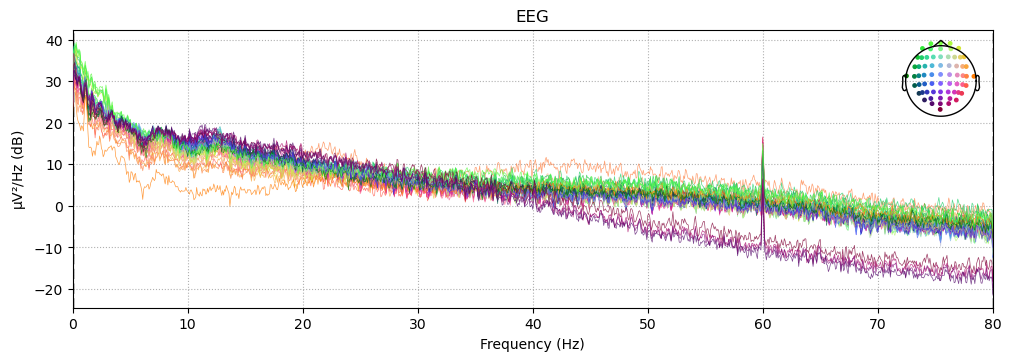

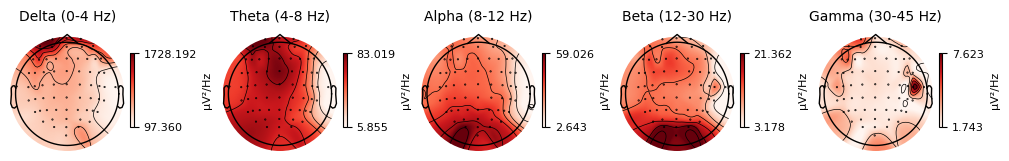

In [5]:
streams.compute_psd().plot();
streams.compute_psd().plot_topomap();

## Preprocessing

In [6]:
def preprocessing(raws_data, event, chans_selected:list):
    # --- Apply Re-reference by Common Average Reference (CAR) ---
    streams = raws_data.copy().set_eeg_reference('average', projection=True)
    streams.apply_proj()
    
    # --- Filter Data ---
    stream_filter = streams.copy().filter(l_freq=8.0, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
    
    # --- Apply ICA ---
    ica = mne.preprocessing.ICA(n_components=63, random_state=97, max_iter=800)
    ica.fit(stream_filter.copy())
    
    # --- Find Bad Components ---
    bad_idx, scores = ica.find_bads_eog(stream_filter.copy(), ch_name='T9', threshold=1.5)
    
    # --- Remove Bad Components ---
    ica.exclude = bad_idx
    
    # --- Apply ICA to Filtered Data ---
    stream_ica = ica.apply(stream_filter.copy(),exclude=ica.exclude)
    
    # --- Events ---
    events, event_dict = mne.events_from_annotations(stream_filter)
    
    # --- Epoch ---
    epochs = mne.Epochs(stream_ica.copy().filter(l_freq=8, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'}), events, tmin = -0.5, tmax = 4, 
                    event_id = event, preload= True, verbose=False, event_repeated='drop')
    
    # --- Selected channels are interested ---
    if chans_selected != 'all':
        epochs = epochs.pick_channels(chans_selected, ordered = False)
    
    # --- Baseline Correction ---
    Baseline = epochs.copy().filter(l_freq=8.0, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
    stream_mi = Baseline.copy().apply_baseline((-0.5, 0))
    
    # --- reject bad channels ---
    def autoreject_epochs(epochs):
        reject = get_rejection_threshold(epochs)  
        reject.update(reject)
        epochs.drop_bad(reject = reject)
        return epochs
    stream_mi = autoreject_epochs(stream_mi.copy())
    
    return stream_mi

In [7]:
epochs = preprocessing(streams, event, chans_selected)
epochs

Estimating rejection dictionary for eeg


Number of events,45
Events,left: 23right: 22
Time range,-0.500 – 4.000 s
Baseline,-0.500 – 0.000 s


In [8]:
data = epochs.get_data(copy=True)

train_X = np.expand_dims(np.moveaxis(data, 0, 0), -1)
train_X.shape

(45, 20, 721, 1)

In [9]:
encoder = OneHotEncoder(sparse_output=False)

y = epochs.events[:, -1]
y = encoder.fit_transform(np.array(y).reshape(-1, 1))
y.shape

(45, 2)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train_X, y, test_size=0.35, random_state=42)
print(f'Number of train set = {X_train.shape[0]}')
print(f'Number of  test set = {X_test.shape[0]}')

Number of train set = 29
Number of  test set = 16


# **Embedded Module**

In [11]:
class MSNN(tf.keras.Model):
    tf.keras.backend.set_floatx("float64")
    def __init__(self):
        super(MSNN, self).__init__()
        self.C = len(chans_selected) # the number of electrodes
        self.fs = 160 # the sampling frequency

        # Regularizer
        self.regularizer = tf.keras.regularizers.L1L2(l1=.001, l2=.01)

        # Activation functions
        self.activation = tf.keras.layers.LeakyReLU()
        self.softmax = tf.keras.layers.Softmax()
        
        # Define convolutions
        conv = lambda D, kernel : tf.keras.layers.Conv2D(D, kernel, kernel_regularizer=self.regularizer)
        sepconv = lambda D, kernel : tf.keras.layers.SeparableConv2D(D, kernel, padding="same",
                                                                    depthwise_regularizer=self.regularizer,
                                                                    pointwise_regularizer=self.regularizer)
        
        # Spectral convoltuion
        self.conv0 = conv(4, (1, int(self.fs/2)))
        
        # Spatio-temporal convolution
        self.conv1t = sepconv(16, (1, 25))
        self.conv1s = conv(16, (self.C, 1))
        
        self.conv2t = sepconv(32, (1, 15))
        self.conv2s = conv(32, (self.C, 1))
        
        self.conv3t = sepconv(64, (1, 6))
        self.conv3s = conv(64, (self.C, 1))

        # Flatteninig
        self.flatten = tf.keras.layers.Flatten()

        # Dropout
        self.dropout = tf.keras.layers.Dropout(0.5)

        # Decision making
        self.dense = tf.keras.layers.Dense(2, activation=None, kernel_regularizer=self.regularizer)

    def embedding(self, x, random_mask=False):
        x = self.activation(self.conv0(x))

        x = self.activation(self.conv1t(x))
        f1 = self.activation(self.conv1s(x))

        x = self.activation(self.conv2t(x))
        f2 = self.activation(self.conv2s(x))

        x = self.activation(self.conv3t(x))
        f3 = self.activation(self.conv3s(x))

        feature = tf.concat((f1, f2, f3), -1)
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.dense(feature))
        return y_hat

    def GAP(self, feature):
        return tf.reduce_mean(feature, -2)

    def call(self, x):
        # Extract feature using MSNN encoder
        feature = self.embedding(x)

        # Global Average Pooling
        feature = self.GAP(feature)

        # Decision making
        y_hat = self.classifier(feature)
        return y_hat

In [12]:
class Shallow_convnet(tf.keras.Model):
    tf.keras.backend.set_floatx("float64")
    def __init__(self):
        super(Shallow_convnet, self).__init__()
        self.C = len(chans_selected) # the number of electrodes
        self.fs = 160 # the sampling frequency

        # Regularizer
        self.regularizer = tf.keras.regularizers.L1L2(l1=.001, l2=.01)

        # Activation functions
        self.activation = tf.keras.layers.LeakyReLU()
        self.softmax = tf.keras.layers.Softmax()
        
        # Define convolutions
        conv = lambda D, kernel : tf.keras.layers.Conv2D(D, kernel, kernel_regularizer=self.regularizer)
        
        # Temporal convoltuion
        self.conv0t = conv(40, (1, int(self.fs/10)))
        
        # Spatial convolution
        self.conv0s = conv(16, (self.C, 40))
        
        # Flatteninig
        self.flatten = tf.keras.layers.Flatten()

        # Dropout
        self.dropout = tf.keras.layers.Dropout(0.5)

        # Decision making
        self.dense = tf.keras.layers.Dense(2, activation=None, kernel_regularizer=self.regularizer)

    def embedding(self, x, random_mask=False):
        x = self.activation(self.conv0t(x))
        f1 = self.activation(self.conv0s(x))

        feature = tf.concat((f1), -1)
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.dense(feature))
        return y_hat

    def GAP(self, feature):
        return tf.reduce_mean(feature, -2)

    def call(self, x):
        # Extract feature using ShallowCovNet encoder
        feature = self.embedding(x)

        # Global Average Pooling
        feature = self.GAP(feature)

        # Decision making
        y_hat = self.classifier(feature)
        return y_hat

In [13]:
# Define the informative segments selection agent module.
# Define actor network (for categorical actions: selection/rejection)
class ACTOR(tf.keras.Model):
    def __init__(self, n_actions=2):
        super().__init__()
        self.actor = tf.keras.layers.Dense(n_actions, activation=None, 
                                          kernel_regularizer=tf.keras.regularizers.L1L2(l1=.001, l2=.01))        
    def call(self, segment):
        return self.actor(segment) # Outputs logit vector.
    
# Define critic network
class CRITIC(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.critic = tf.keras.layers.Dense(1, activation=None,
                                           kernel_regularizer=tf.keras.regularizers.L1L2(l1=.001, l2=.01))
    def call(self, segment):
        return tf.keras.activations.sigmoid(self.critic(segment))

In [14]:
# Define utility functions.
def gradient(model, inputs, labels, mask=None):
    with tf.GradientTape() as tape:
        if mask is None:
            yhat = model(inputs)
        else:
            feature = model.GAP(model.embedding(inputs) * mask)
            yhat = model.classifier(feature)

        loss = tf.keras.losses.binary_crossentropy(labels, yhat)

    grad = tape.gradient(loss, model.trainable_variables)
    return loss, grad

def agent_gradient(model, actor, critic, inputs, feature, labels, state, state_next):
    gamma = 0.95 # discount factor
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        loss_FM = tf.keras.losses.binary_crossentropy(labels, model(inputs))
        loss_AM = tf.keras.losses.binary_crossentropy(labels, model.classifier(feature))

        # Reward, r_t
        reward = loss_FM - loss_AM
        # Advantage, A_t
        advantage = reward[:, None] + gamma * critic(state_next) - critic(state)            
        # Critic loss
        critic_loss = 0.5 * tf.math.square(advantage)            
        # Actor loss
        actor_loss = -tf.math.log(tf.nn.softmax(actor(state))) * advantage

    critic_grad = tape1.gradient(critic_loss, critic.trainable_variables)
    # print("critic_grad: ", critic_grad)
    actor_grad = tape2.gradient(actor_loss, actor.trainable_variables)
    return critic_loss, critic_grad, actor_loss, actor_grad

In [17]:
# Define experiment conducting class.
# Here, we trained and tested MSNN without the proposed agent module.
class experiment():
    def __init__(self, train_X, train_Y, test_X, test_Y):
        # Load dataset.
        # For simplicity, we just removed validating phase here.
        self.Xtr, self.Ytr = train_X, train_Y
        self.Xts, self.Yts = test_X, test_Y
        self.Yts = np.argmax(self.Yts, axis=-1) # To use scikit-learn accuracy function
        
        # Randomize the training dataset.
        rand_idx = np.random.permutation(self.Xtr.shape[0])
        self.Xtr, self.Ytr = self.Xtr[rand_idx, :, :, :], self.Ytr[rand_idx, :]

        # Learning schedules
        self.init_LR = 1e-3
        self.num_epochs_pre = 20 # Pre-training epochs
        self.num_epochs = 30
        self.num_batch = 20
        self.optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=self.init_LR)
        
        # Here, we used subject 1's 2nd session data.
        # self.sbj_idx, self.sess_idx = 1, 2
        # print(f"START TRAINING Subject {self.sbj_idx}, Session {self.sess_idx}")
        
        # Call optimizer.
        self.num_batch_iter = int(self.Xtr.shape[0]/self.num_batch)
        
    def training_FM(self):
        # Call MSNN.
        msnn = Shallow_convnet()
        
        # To record the loss curve.
        loss_FM = []
        for epoch in range(self.num_epochs):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                # Estimate loss
                loss, grads = gradient(msnn, xb, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, msnn.trainable_variables))
                loss_FM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Test the learned model.
        Yts_hat = np.argmax(msnn(X_test), axis=-1)
        # print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx},\
        print(f"Testing accuracy: {accuracy_score(self.Yts, Yts_hat)}!\n")
        return loss_FM
    
    def training_AM(self):
        # Call MSNN.
        msnn = Shallow_convnet()
        
        # To record the loss curve.
        loss_AM = []
        # Pre-training without the agent module
        for epoch in range(self.num_epochs_pre):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                # Estimate loss
                loss, grads = gradient(msnn, xb, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, msnn.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Call agent module.
        actor = ACTOR()
        critic = CRITIC()
        
        # Training with the agent module
        for epoch in range(self.num_epochs - self.num_epochs_pre):
            loss_per_epoch = 0
            
            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]
                # Extract full segments.
                features = msnn.embedding(xb)
                
                agg_wo_current = np.zeros((self.num_batch, features.shape[-1]))
                num_added = np.zeros((self.num_batch, features.shape[-1])) # To estimate the denominator.
                mask = np.zeros(features.shape) # Mask generated by the agent module
                for t in range(features.shape[-2] - 1): # t = 1,...,T'
                    print('epoch :',epoch, 'batch :', batch, 't :', t)
                    deno1 = np.copy(num_added)
                    deno2 = np.copy(num_added) + 1 # For the features with the current segment.
                    # To avoid zero-division.
                    deno1[deno1 == 0] = 1.
                    
                    agg_w_current = agg_wo_current + features[:, 0, t, :]
                    
                    # Define state, s_t.
                    state = np.concatenate((agg_wo_current/deno1, agg_w_current/deno2), axis=-1)
                    # Get action, a_t.
                    action_probs = actor(state)
                    action = np.tile(tf.random.categorical(action_probs, 1).numpy(), 16) # (5, 112)
                    mask[:, 0, t, :] = action
                    num_added += action
                    
                    # Current feature after action decision, phi_t.
                    deno3 = np.copy(num_added)
                    deno3[deno3 == 0] = 1 # To avoid zero-division.
                    feature = (agg_wo_current + features[:, 0, t, :] * action)/deno3
                    
                    # Define next state, s_{t+1}, temporally.
                    agg_wo_current = feature
                    tmp = agg_wo_current + features[:, 0, t + 1, :]
                    state_next = np.concatenate((agg_wo_current/deno3, tmp/(deno3 + 1)), axis=-1)

                    # Calculate critic and actor loss values
                    critic_loss, critic_grads, actor_loss, actor_grads =\
                    agent_gradient(msnn, actor, critic, xb, feature, yb, state, state_next)
                    
                    # print(actor_grads)
                    
                    self.optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
                    # print("critic :",critic.trainable_variables)
                    self.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
                                        
                # Finally, predict labels of input EEG using the selected segments.                
                # Update the parameters
                loss, grads = gradient(msnn, xb, yb, mask)
                self.optimizer.apply_gradients(zip(grads, msnn.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)
                
            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1 + self.num_epochs_pre}, Training Loss {loss_per_epoch:>.04f}")
        
        # Test the learned model.
        Yts_hat = np.argmax(msnn(X_test), axis=-1)
        # print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx}, \
        print(f"\nTesting accuracy: {accuracy_score(self.Yts, Yts_hat)}!\n")
        return loss_AM

with tf.device('/gpu:1'):
    exp = experiment(X_train, y_train, X_test, y_test)
    loss_FM = exp.training_FM()
    loss_AM = exp.training_AM()

Iteration 1, Training Loss 0.6931
Iteration 2, Training Loss 0.6731
Iteration 3, Training Loss 1.1486
Iteration 4, Training Loss 0.6741
Iteration 5, Training Loss 0.6783
Iteration 6, Training Loss 0.6745
Iteration 7, Training Loss 0.6730
Iteration 8, Training Loss 0.6730
Iteration 9, Training Loss 0.6730
Iteration 10, Training Loss 0.6730
Iteration 11, Training Loss 0.6730
Iteration 12, Training Loss 0.6730
Iteration 13, Training Loss 0.6730
Iteration 14, Training Loss 0.6730
Iteration 15, Training Loss 0.6730
Iteration 16, Training Loss 0.6730
Iteration 17, Training Loss 0.6730


KeyboardInterrupt: 

In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [ ]:
msnn = Shallow_convnet()
msnn.trainable_variables

[]

In [ ]:
y_test

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [ ]:
y_test.shape

(16, 2)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
np.argmax(y_test, axis=-1)

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1], dtype=int64)

In [ ]:
np.random.permutation(X_train.shape[0])

array([22, 27, 26,  3, 23,  8,  6,  7, 19, 14, 10, 11,  4,  2, 18, 21,  1,
       28, 20,  9, 13, 16, 25, 24,  0, 17, 12, 15,  5])

In [ ]:
x = tf.constant([[1., 1.], [2., 2.], [3., 2.]])

In [ ]:
tf.reduce_mean(x, axis = -2)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.       , 1.6666666], dtype=float32)>